#Import library

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Detection Bubble Financial

In [26]:
prices_df = pd.read_excel('K214140948_bubbles.xlsx')
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
prices_df.set_index('Date', inplace=True)

prices_df['bubble'] = 0
bubble_dates = ['2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31']
prices_df.loc[prices_df.index.isin(bubble_dates), 'bubble'] = 1

print(prices_df)

              Close  bubble
Date                       
2009-01-31   300.48       0
2009-02-28   240.11       0
2009-03-31   276.99       0
2009-04-30   325.52       0
2009-05-31   416.94       0
...             ...     ...
2024-01-31  1166.33       0
2024-02-29  1265.75       0
2024-03-31  1296.90       0
2024-04-30  1240.50       0
2024-05-31  1284.02       0

[185 rows x 2 columns]


In [27]:
num_bubbles = (prices_df['bubble'] == 1).sum()

print(f"Số lượng giá trị 'Bubble' là 1 trong merged_data_weekly là: {num_bubbles}")

Số lượng giá trị 'Bubble' là 1 trong merged_data_weekly là: 5


#Macroeconomic index

In [28]:
file_path = 'K214140948_finance.xlsx'
data = pd.read_excel(file_path, sheet_name='data')
df = data
df['Year'] = df['Date'].str.extract(r'(\d{4})')[0]
df['Quarter'] = df['Date'].str.extract(r'(Q\d)')[0]

quarter_to_month = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}
df['Month'] = df['Quarter'].map(quarter_to_month)

df['Date'] = pd.to_datetime(df['Year'] + '-' + df['Month'])
df.drop(columns=['Year', 'Quarter', 'Month'], inplace=True)
df.set_index('Date', inplace=True)

monthly_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='M')
data_monthly = df.reindex(monthly_index)
data_interpolated = data_monthly.interpolate(method='cubic')
data_interpolated.head(15)

,GDP,CPI,Interest Rate,M3,Unemployment rate
2008-06-30,22.847000,85.500000,15.000000,1.295492e+06,2.310000
2008-07-31,20.581357,87.870019,16.120904,1.287748e+06,2.350882
2008-08-31,21.234470,89.222670,15.984888,1.308190e+06,2.390775
2008-09-30,23.426000,89.800000,15.000000,1.347514e+06,2.430000
2008-10-31,26.041834,89.885377,13.455525,1.400803e+06,2.472784
2008-11-30,27.706904,89.707699,11.790869,1.457401e+06,2.517910
2008-12-31,27.272000,89.500000,10.250000,1.513544e+06,2.570000
2009-01-31,24.022747,89.464688,9.163681,1.561830e+06,2.628545
2009-02-28,20.307551,89.575353,8.511208,1.601283e+06,2.685329
2009-03-31,17.770000,89.800000,8.000000,1.645309e+06,2.750000


In [29]:
inflation_data = pd.read_excel(file_path, sheet_name='Inflation')
inflation_data['Date'] = pd.to_datetime(inflation_data['Date'])
inflation_data.set_index('Date', inplace=True)

In [30]:
merged_data = data_interpolated.merge(inflation_data, left_index=True, right_index=True, how='left')
merged_data.head(15)

,GDP,CPI,Interest Rate,M3,Unemployment rate,Inflation Rate
2008-06-30,22.847000,85.500000,15.000000,1.295492e+06,2.310000,2.13
2008-07-31,20.581357,87.870019,16.120904,1.287748e+06,2.350882,1.12
2008-08-31,21.234470,89.222670,15.984888,1.308190e+06,2.390775,1.56
2008-09-30,23.426000,89.800000,15.000000,1.347514e+06,2.430000,0.18
2008-10-31,26.041834,89.885377,13.455525,1.400803e+06,2.472784,-0.19
2008-11-30,27.706904,89.707699,11.790869,1.457401e+06,2.517910,-0.75
2008-12-31,27.272000,89.500000,10.250000,1.513544e+06,2.570000,-0.68
2009-01-31,24.022747,89.464688,9.163681,1.561830e+06,2.628545,0.31
2009-02-28,20.307551,89.575353,8.511208,1.601283e+06,2.685329,1.17
2009-03-31,17.770000,89.800000,8.000000,1.645309e+06,2.750000,-0.17


# Visualize data

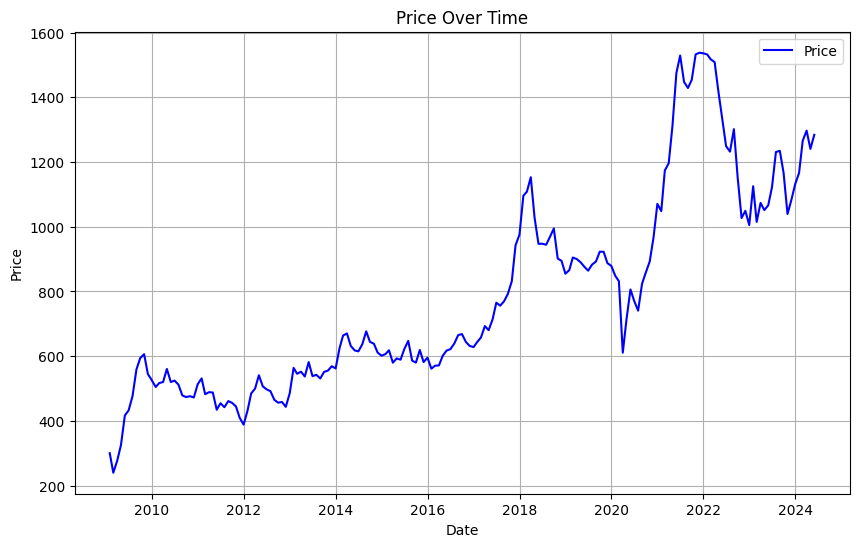

In [31]:
prices = prices_df['Close']

plt.figure(figsize=(10, 6))
plt.plot(prices, label='Price', color='blue')
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
descriptive_prices = prices.describe()
print("Thống kê mô tả cho biến Price:")
descriptive_prices.head(10)

Thống kê mô tả cho biến Price:


count     185.000000
mean      782.739405
std       313.609008
min       240.110000
25%       542.520000
50%       647.360000
75%       994.730000
max      1537.590000
Name: Close, dtype: float64

In [33]:
# Tính toán thống kê mô tả
descriptive_inf = inflation_data.describe()
print("Thống kê mô tả cho biến Price:")
descriptive_inf.head(10)

Thống kê mô tả cho biến Price:


,Inflation Rate
count,194.000000
mean,0.440464
std,0.683317
min,-1.540000
25%,0.070000
50%,0.310000
75%,0.620000
max,3.910000


In [34]:
descriptive_stats = data.describe()
print("Thống kê mô tả cho các biến trong bộ dữ liệu:")
descriptive_stats.head(10)

Thống kê mô tả cho các biến trong bộ dữ liệu:


,GDP,CPI,Interest Rate,M3,Unemployment rate
count,63.000000,63.000000,63.000000,6.300000e+01,63.000000
mean,55.355206,143.347619,7.242063,6.710587e+06,2.383333
std,27.440788,28.644567,2.915119,4.023430e+06,0.369708
min,17.770000,85.500000,4.000000,1.295492e+06,1.900000
25%,33.297000,127.800000,6.000000,2.907216e+06,2.185000
50%,48.383000,145.700000,6.500000,6.038555e+06,2.280000
75%,71.274500,166.900000,8.000000,1.003084e+07,2.435000
max,121.211000,186.200000,15.000000,1.423497e+07,3.980000


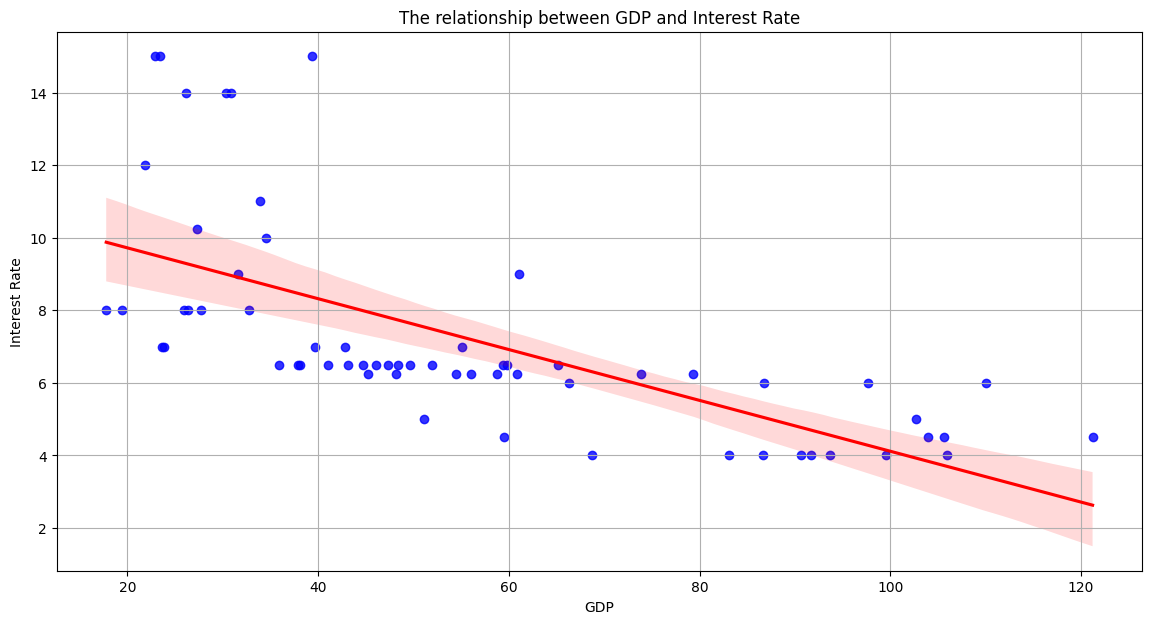

In [35]:
plt.figure(figsize=(14, 7))
sns.regplot(x=data['GDP'], y=data['Interest Rate'], scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('GDP')
plt.ylabel('Interest Rate')
plt.title('The relationship between GDP and Interest Rate')
plt.grid(True)
plt.show()

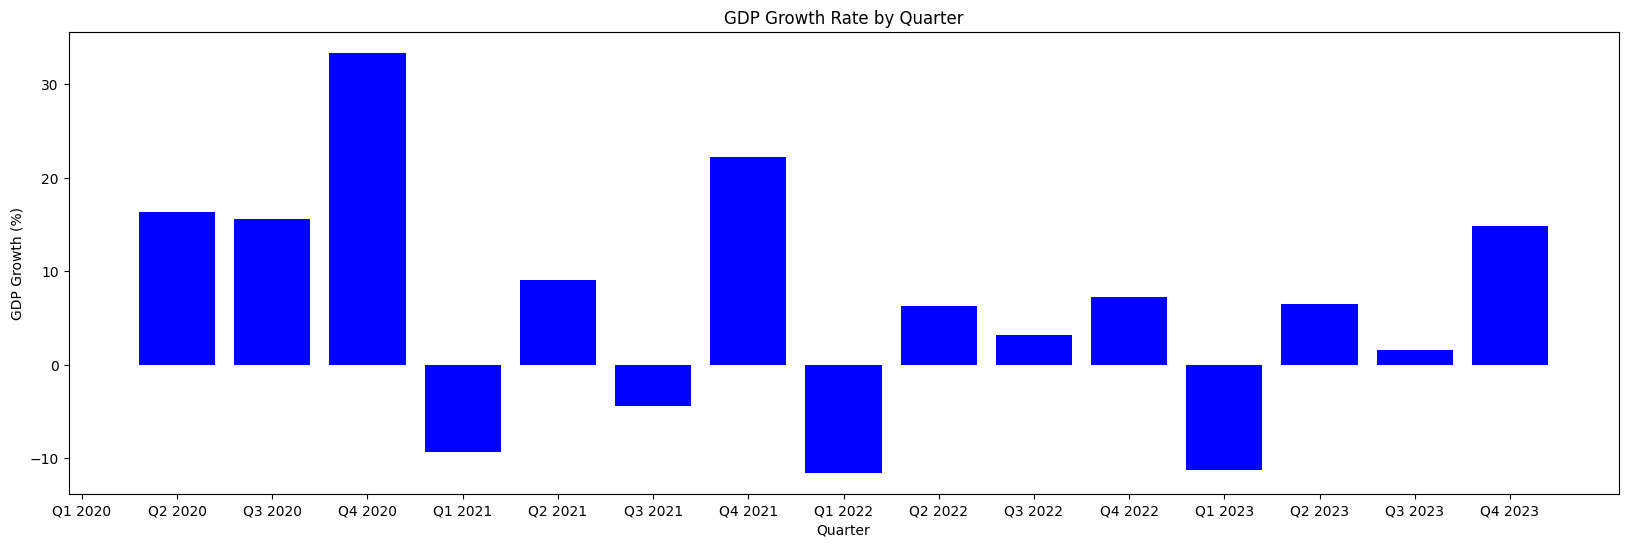

In [36]:
file_path = 'BN (2).xlsx'
df = pd.read_excel(file_path, sheet_name='data')
df = df[df['Date'].str.contains('2020|2021|2022|2023')]

df['GDP_Growth'] = df['GDP'].pct_change() * 100

plt.figure(figsize=(20, 6))
plt.bar(df['Date'], df['GDP_Growth'], color='blue')
plt.title('GDP Growth Rate by Quarter')
plt.xlabel('Quarter')
plt.ylabel('GDP Growth (%)')
plt.show()


#Final Data

In [37]:
final_df = prices_df.merge(merged_data, how='inner', left_index=True, right_index=True)
columns_to_drop = ['Close']
final_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
final_df.head(10)

,bubble,GDP,CPI,Interest Rate,M3,Unemployment rate,Inflation Rate
2009-01-31,0,24.022747,89.464688,9.163681,1.561830e+06,2.628545,0.31
2009-02-28,0,20.307551,89.575353,8.511208,1.601283e+06,2.685329,1.17
2009-03-31,0,17.770000,89.800000,8.000000,1.645309e+06,2.750000,-0.17
2009-04-30,0,18.555153,90.074645,7.592803,1.691340e+06,2.811708,0.35
2009-05-31,0,21.290775,90.413106,7.247253,1.737961e+06,2.870889,0.43
2009-06-30,0,23.645000,90.800000,7.000000,1.775952e+06,2.920000,0.55
2009-07-31,0,24.175026,91.255735,6.852455,1.803558e+06,2.958727,0.51
2009-08-31,0,23.731618,91.714732,6.844300,1.823717e+06,2.982775,0.23
2009-09-30,0,23.881000,92.100000,7.000000,1.842315e+06,2.990000,0.62
2009-10-31,0,25.592595,92.423346,7.331396,1.865212e+06,2.980940,0.37


In [38]:
num_bubbles = (final_df['bubble'] == 1).sum()

print(f"Số lượng giá trị 'Bubble' là 1 trong merged_data_weekly là: {num_bubbles}")

Số lượng giá trị 'Bubble' là 1 trong merged_data_weekly là: 5


In [39]:
print(final_df.isna().sum())

bubble               0
GDP                  0
CPI                  0
Interest Rate        0
M3                   0
Unemployment rate    0
Inflation Rate       0
dtype: int64


In [40]:
final_df = final_df.dropna()

#Model and evaluation

In [41]:
X = final_df.drop(columns=['bubble'])
y = final_df['bubble']

In [42]:
skf = StratifiedKFold(n_splits=5)

In [43]:
smote = SMOTE(random_state=42, k_neighbors=2)

In [44]:
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {model_name: {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [], "gini": []} for model_name in models}

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    for model_name, model in models.items():
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        gini = 2 * roc_auc - 1

        results[model_name]["accuracy"].append(accuracy)
        results[model_name]["precision"].append(precision)
        results[model_name]["recall"].append(recall)
        results[model_name]["f1"].append(f1)
        results[model_name]["auc"].append(roc_auc)
        results[model_name]["gini"].append(gini)

summary_results = {
    model_name: {
        "Accuracy": np.mean(metrics["accuracy"]),
        "Precision": np.mean(metrics["precision"]),
        "Recall": np.mean(metrics["recall"]),
        "F1 Score": np.mean(metrics["f1"]),
        "AUC": np.mean(metrics["auc"]),
        "Gini": np.mean(metrics["gini"])
    }
    for model_name, metrics in results.items()
}

results_df = pd.DataFrame(summary_results).T
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   Accuracy  Precision  Recall  F1 Score       AUC      Gini
SVM                0.661111   0.612727     1.0  0.624668  0.902857  0.805714
Random Forest      0.883333   0.410000     0.6  0.419048  1.000000  1.000000
Gradient Boosting  0.905556   0.412500     0.6  0.423529  0.745714  0.491429


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

# Assuming X, y, and smote are already defined
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {model_name: {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [], "gini": [], "predictions": []} for model_name in models}

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    for model_name, model in models.items():
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        gini = 2 * roc_auc - 1

        results[model_name]["accuracy"].append(accuracy)
        results[model_name]["precision"].append(precision)
        results[model_name]["recall"].append(recall)
        results[model_name]["f1"].append(f1)
        results[model_name]["auc"].append(roc_auc)
        results[model_name]["gini"].append(gini)
        results[model_name]["predictions"].append(y_pred)  # Store predictions

summary_results = {
    model_name: {
        "Accuracy": np.mean(metrics["accuracy"]),
        "Precision": np.mean(metrics["precision"]),
        "Recall": np.mean(metrics["recall"]),
        "F1 Score": np.mean(metrics["f1"]),
        "AUC": np.mean(metrics["auc"]),
        "Gini": np.mean(metrics["gini"])
    }
    for model_name, metrics in results.items()
}

results_df = pd.DataFrame(summary_results).T
print(results_df)

# Print the predictions for each model
for model_name, metrics in results.items():
    print(f"\nPredictions for {model_name}:")
    for fold_idx, fold_predictions in enumerate(metrics["predictions"]):
        print(f"Fold {fold_idx + 1}: {fold_predictions}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

                   Accuracy  Precision  Recall  F1 Score       AUC      Gini
SVM                0.727778   0.095649     1.0  0.174141  0.994286  0.988571
Random Forest      0.977778   0.466667     0.6  0.500000  0.988571  0.977143
Gradient Boosting  0.977778   0.466667     0.6  0.500000  0.822857  0.645714

Predictions for SVM:
Fold 1: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Fold 2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Fold 3: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Fold 4: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Fold 5: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]

Predictions for Random Forest:
Fold 1: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fold 2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fold 3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0